In [1]:
import tensorflow as tf
print("tensorflow version is", tf.__version__)
print("keras version is", tf.keras.__version__)

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.initializers import RandomNormal
import os
import matplotlib.pyplot as plt
import numpy as np

plt.ioff()  # not to show images inline
os.makedirs("out2", exist_ok=True)

tensorflow version is 2.1.0
keras version is 2.2.4-tf


In [2]:
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
print("data shape:", x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)
print("image data range:", np.min(x_tr), np.max(x_tr))

data shape: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
image data range: 0 255


* sample training images *


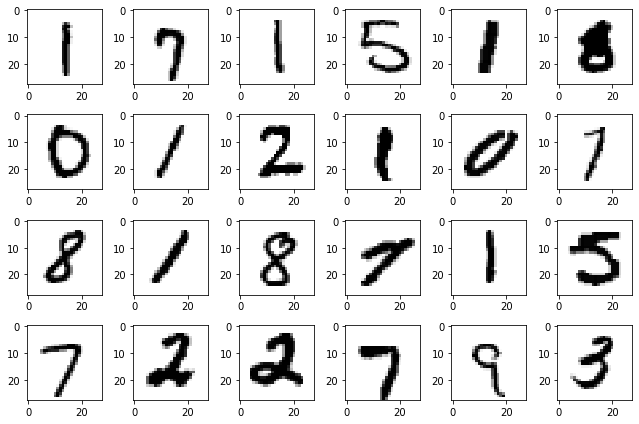

In [3]:
def plot_images(x, figsize=(9, 6), nrow=4, ncol=6):
    ix = np.random.choice(len(x), size=nrow*ncol, replace=False)
    images = x[ix]
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
    k = 0
    for i in range(nrow):
        for j in range(ncol):
            ax = axes[i][j]
            ax.imshow(images[k], cmap="gray_r")
            k += 1
    fig.tight_layout()
    return fig
print("* sample training images *")
plot_images(x_tr)

In [4]:
class RealDataset:
    def __init__(self, data, normalizer=None):
        self.data = np.expand_dims(data.astype("float32"), axis=-1)  # add channels dimension
        self.normalizer = normalizer
        self.index = 0  # current index
        self.iter_count = 0  # number of completed iteration
        self.randomize()

    def randomize(self):
        n = len(self.data)
        ix = np.random.permutation(n)
        self.data = self.data[ix]
    
    def get(self, size):
        out = self._get(size)
        if self.normalizer is None:
            return out
        else:
            return self.normalizer(out)

    def _get(self, size):
        n = len(self.data)
        i1 = self.index
        i2 = min(n, self.index + size)
        if i2 >= n:
            self.iter_count += 1
            self.randomize()
        out = self.data[i1:i2]
        self.index = (i2 % n)
        if len(out) == size:
            return out
        else:
            size_remain = size - len(out)
            out2 = self.get(size_remain)
            out = np.vstack((out, out2))
            return out


class Normalizer:
    def __init__(self, low=-1.0, high=1.0):
        self.low = low
        self.high = high
    
    def __call__(self, x):
        return x * (self.high - self.low) / 255.0 + self.low

(12, 28, 28) -1.0 1.0


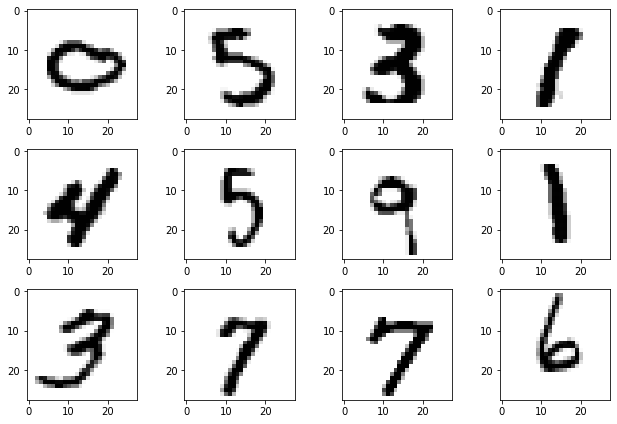

In [5]:
real_data = RealDataset(x_tr, normalizer=Normalizer())
test = real_data.get(12).squeeze()
print(test.shape, np.min(test), np.max(test))
plot_images(test, nrow=3, ncol=4)

In [6]:
def make_discriminator(filters=(64,64), kernel=(3,3), batch_norm=False, input_shape=(28,28,1)):
    initializer = RandomNormal(0.0, 0.02)
    model = Sequential()
    for i, f in enumerate(filters):
        if i == 0:
            layer = Conv2D(f, kernel, strides=(2,2), padding="same",
                           input_shape=input_shape, kernel_initializer=initializer)
        else:
            layer = Conv2D(f, kernel, strides=(2,2), padding="same", kernel_initializer=initializer)
        model.add(layer)
        if batch_norm:
            model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid", kernel_initializer=initializer))
    return model

def make_discriminator_functional(filters=(64,64), kernel=(3,3), batch_norm=False, input_shape=(28,28,1)):
    initializer = RandomNormal(0.0, 0.02)
    x = Input(input_shape)    
    y = x
    for f in filters:
        y = Conv2D(f, kernel, strides=(2,2), padding="same", kernel_initializer=initializer)(y)
        if batch_norm:
            y = BatchNormalization()(y)
        y = LeakyReLU(0.2)(y)
        y = Dropout(0.4)(y)
    y = Flatten()(y)
    y = Dense(1, activation="sigmoid", kernel_initializer=initializer)(y)
    model = Model(inputs=x, outputs=y)
    return model

discriminator = make_discriminator()
discriminator.summary()
print("***")
discriminator = make_discriminator_functional()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [7]:
def make_generator(input_size=100, filters=(128,128), init_filter=128, init_shape=(7, 7),
                   batch_norm=False):
    initializer = RandomNormal(0.0, 0.02)
    model = Sequential()
    n = init_filter * init_shape[0] * init_shape[1]
    model.add(Dense(n, input_dim=input_size, kernel_initializer=initializer))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Reshape(init_shape + (init_filter,)))
    for f in filters:
        layer = Conv2DTranspose(f, (4,4), strides=(2,2), padding="same", kernel_initializer=initializer)
        model.add(layer)
        if batch_norm:
            model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
    model.add(Conv2D(1, (7,7), activation="tanh", padding="same", kernel_initializer=initializer))
    return model

def make_generator_functional(input_size=100, filters=(128,128), init_filter=128, init_shape=(7, 7),
                              batch_norm=False):
    initializer = RandomNormal(0.0, 0.02)
    x = Input((input_size,))
    y = x
    n = init_filter * init_shape[0] * init_shape[1]
    y = Dense(n, kernel_initializer=initializer)(y)
    if batch_norm:
        y = BatchNormalization()(y)
    y = LeakyReLU(0.2)(y)
    y = Reshape(init_shape + (init_filter,))(y)
    for f in filters:
        y = Conv2DTranspose(f, (4,4), strides=(2,2), padding="same", kernel_initializer=initializer)(y)
        if batch_norm:
            y = BatchNormalization()(y)
        y = LeakyReLU(0.2)(y)
    y = Conv2D(1, (7,7), activation="tanh", padding="same", kernel_initializer=initializer)(y)
    model = Model(inputs=x, outputs=y)
    return model

generator = make_generator()
generator.summary()
print("***")
generator = make_generator_functional()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 128)      

(6, 28, 28) -0.07299948 0.068846695


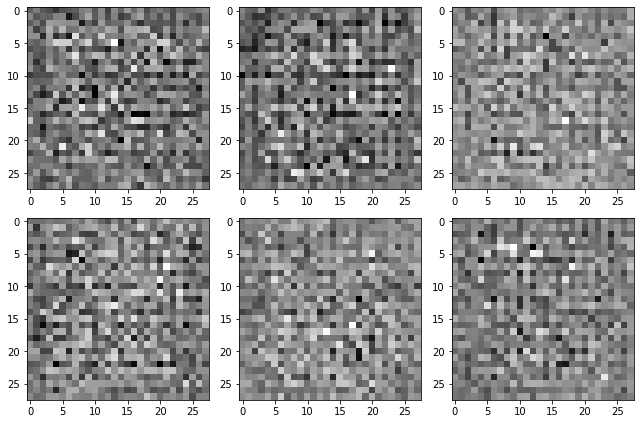

In [8]:
def generate_latent(generator, n_sample=128):
    latent_size = generator.input_shape[1]
    latent = np.random.randn(n_sample, latent_size)
    return latent

def generate_fake_data(generator, n_sample=128):
    latent = generate_latent(generator, n_sample)
    out = generator.predict(latent)
    return out

fake = generate_fake_data(generator, 6).squeeze()  # remove the channels dimension
print(fake.shape, np.min(fake), np.max(fake))
plot_images(fake, nrow=2, ncol=3)

In [9]:
class GAN:
    def __init__(self, generator, discriminator, data, test_data,
                 name="mnist", functional=False, **kwargs):
        self.generator = generator
        self.discriminator = discriminator
        self.data = data
        self.test_data = test_data
        self.name = name
        self.setup(functional=functional, **kwargs)
        
    def setup(self, functional=False,
              lr_d=0.0002, beta1_d=0.5, beta2_d=0.999,
              lr_g=0.0002, beta1_g=0.5, beta2_g=0.999):
        self.discriminator.trainable = True
        opt = Adam(learning_rate=lr_d, beta_1=beta1_d, beta_2=beta2_d)
        self.discriminator.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
        
        self.discriminator.trainable = False
        if functional:
            x = Input(self.generator.input_shape[1:])
            y = self.generator(x)
            y = self.discriminator(y)
            gan = Model(inputs=x, outputs=y)
        else:
            gan = Sequential([self.generator, self.discriminator])
        opt = Adam(learning_rate=lr_g, beta_1=beta1_g, beta_2=beta2_g)
        gan.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
        self.gan = gan
    
    def train_step(self, batchsize=256, update_discriminator_separately=True):
        # train discriminator
        halfbatch = int(batchsize/2)
        x_real = self.data.get(halfbatch)
        y_real = np.ones((halfbatch, 1))
        x_fake = generate_fake_data(self.generator, halfbatch)
        y_fake = np.zeros((halfbatch, 1))
        if update_discriminator_separately:
            res_d_real = self.discriminator.train_on_batch(x_real, y_real)        
            res_d_fake = self.discriminator.train_on_batch(x_fake, y_fake)
            res_d = tuple((a+b)/2 for a, b in zip(res_d_real, res_d_fake))
        else:
            res_d = self.discriminator.train_on_batch(
                np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            )
        
        # train generator
        x_gan = generate_latent(self.generator, batchsize)
        y_gan = np.ones((batchsize, 1))
        res_g = self.gan.train_on_batch(x_gan, y_gan)
        
#        return res_d_real, res_d_fake, res_g
        return res_d, res_g
    
    def evaluate(self, iteration, batchsize=512):
        x_real = self.test_data.get(batchsize)
        y_real = np.ones((batchsize, 1))
        loss_real, acc_real = self.discriminator.evaluate(x_real, y_real, verbose=False)
        x_fake = generate_fake_data(self.generator, batchsize)
        y_fake = np.zeros((batchsize, 1))
        loss_fake, acc_fake = self.discriminator.evaluate(x_fake, y_fake, verbose=False)
        print("\nIter %d: loss=(%.3f, %.3f), acc=(%.3f, %.3f)" % (
              iteration+1, loss_real, loss_fake, acc_real, acc_fake))
        
    def generate_sample(self, nrow=4, ncol=6, figsize=(10, 6)):
        fake = generate_fake_data(self.generator, nrow*ncol).squeeze()
        images = plot_images(fake, figsize=figsize, nrow=nrow, ncol=ncol)
        return images
    
    def save_model(self, index):
        path = "out2/mnist-generator_%07d.h5" % (index)
        self.generator.save(path)
        path = "out2/mnist-discriminator_%07d.h5" % (index)
        self.discriminator.save(path)
        
    def train(self, n_iter=10000, batchsize=256, update_discriminator_separately=True,
              eval_by=1000, batchsize_eval=128, nrow=4, ncol=6, figsize=(10, 6)):
        # image from the initial generator
        fig = self.generate_sample(nrow=nrow, ncol=ncol, figsize=figsize)
        imagepath = "out2/mnist_%07d.png" % 0
        fig.savefig(imagepath)
        plt.close(fig)
        history = {"loss_d":[], "loss_g":[], "acc_d":[], "acc_g":[]}
        for i in range(n_iter):
            (loss_d, acc_d), (loss_g, acc_g) = self.train_step(
                batchsize, update_discriminator_separately=update_discriminator_separately)
            print("\r#%6d: loss=(%.3f, %.3f), acc=(%.3f, %.3f)" % (i+1, loss_d, loss_g, acc_d, acc_g), end="")
            history["loss_d"].append(loss_d)
            history["loss_g"].append(loss_g)
            history["acc_d"].append(acc_d)
            history["acc_g"].append(acc_g)
            if (i+1) % eval_by == 0:
                self.evaluate(i, batchsize_eval)
                fig = self.generate_sample(nrow=nrow, ncol=ncol, figsize=figsize)
                imagepath = "out2/%s_%07d.png" % (self.name, i+1)
                fig.savefig(imagepath)
                plt.close(fig)
                self.save_model(i+1)
        return history

# test
gan = GAN(generator, discriminator, real_data, real_data, name="test")
history = gan.train(n_iter=10, batchsize=64, eval_by=2)

#     2: loss=(0.691, 0.692), acc=(0.391, 1.000)
Iter 2: loss=(0.672, 0.695), acc=(1.000, 0.000)
#     4: loss=(0.680, 0.688), acc=(0.500, 1.000)
Iter 4: loss=(0.647, 0.701), acc=(1.000, 0.000)
#     6: loss=(0.673, 0.677), acc=(0.500, 1.000)
Iter 6: loss=(0.619, 0.716), acc=(1.000, 0.000)
#     8: loss=(0.668, 0.655), acc=(0.500, 1.000)
Iter 8: loss=(0.590, 0.747), acc=(1.000, 0.000)
#    10: loss=(0.676, 0.626), acc=(0.500, 1.000)
Iter 10: loss=(0.574, 0.782), acc=(1.000, 0.000)


(12, 28, 28) -0.97645664 -0.062102366


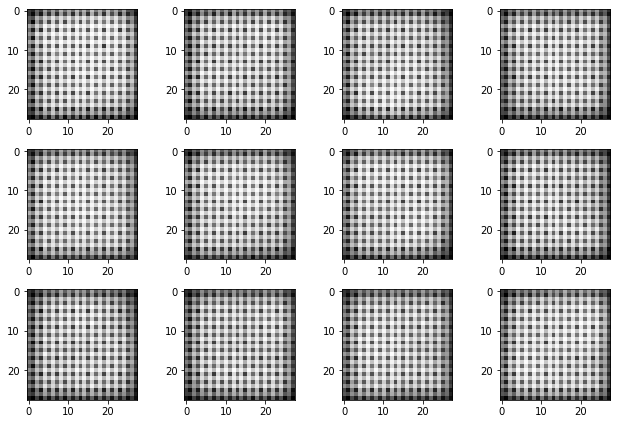

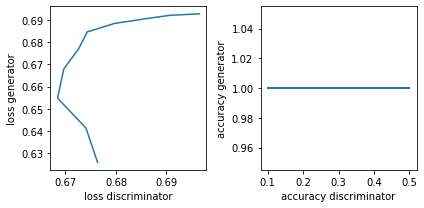

In [10]:
def post_estimation_summary(gan, history):
    fake = generate_fake_data(gan.generator, 12).squeeze()  # remove the channels dimension
    print(fake.shape, np.min(fake), np.max(fake))
    fig = plot_images(fake, nrow=3, ncol=4)
    display(fig)
    plt.close(fig)
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].plot(history["loss_d"], history["loss_g"])
    ax[0].set_xlabel("loss discriminator")
    ax[0].set_ylabel("loss generator")
    ax[1].plot(history["acc_d"], history["acc_g"])
    ax[1].set_xlabel("accuracy discriminator")
    ax[1].set_ylabel("accuracy generator")
    fig.tight_layout()
    display(fig)
    plt.close(fig)

# test
post_estimation_summary(gan, history)

#  1000: loss=(0.001, 6.193), acc=(1.000, 0.000))
Iter 1000: loss=(0.010, 0.002), acc=(0.992, 1.000)
#  2000: loss=(0.000, 8.001), acc=(1.000, 0.000)
Iter 2000: loss=(0.001, 0.000), acc=(1.000, 1.000)
#  3000: loss=(0.000, 7.954), acc=(1.000, 0.000)
Iter 3000: loss=(0.000, 0.000), acc=(1.000, 1.000)
#  4000: loss=(0.000, 9.826), acc=(1.000, 0.000)
Iter 4000: loss=(0.000, 0.000), acc=(1.000, 1.000)
#  5000: loss=(0.023, 4.603), acc=(0.996, 0.000))
Iter 5000: loss=(0.018, 0.010), acc=(0.992, 1.000)
#  6000: loss=(0.005, 6.206), acc=(1.000, 0.000)
Iter 6000: loss=(0.002, 0.002), acc=(1.000, 1.000)
#  7000: loss=(0.904, 0.726), acc=(0.348, 0.516)
Iter 7000: loss=(0.849, 0.790), acc=(0.297, 0.391)
#  8000: loss=(0.727, 0.718), acc=(0.430, 0.469)
Iter 8000: loss=(0.686, 0.711), acc=(0.508, 0.477)
#  9000: loss=(0.694, 0.729), acc=(0.512, 0.336)
Iter 9000: loss=(0.690, 0.678), acc=(0.547, 0.656)
# 10000: loss=(0.694, 0.700), acc=(0.531, 0.473)
Iter 10000: loss=(0.669, 0.697), acc=(0.766, 0.46

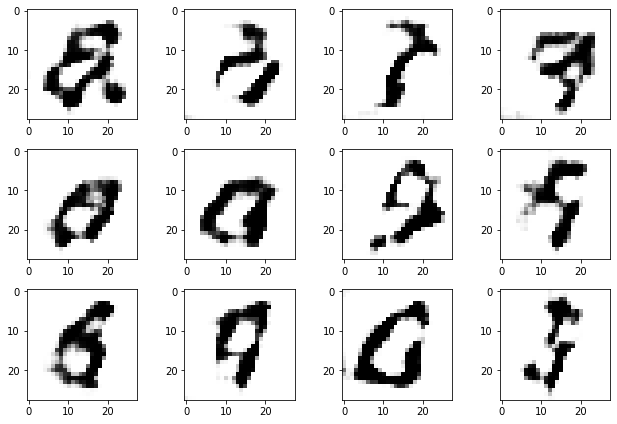

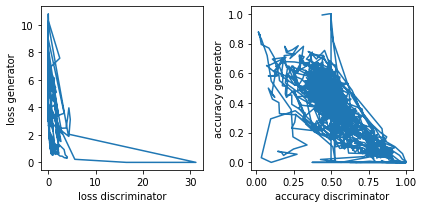

In [11]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator()
generator = make_generator()
gan = GAN(generator, discriminator, data, test_data, name="mnist-sequential")
history = gan.train(n_iter=10000)

post_estimation_summary(gan, history)

#  1000: loss=(0.000, 0.030), acc=(1.000, 1.000)
Iter 1000: loss=(0.000, 4.366), acc=(1.000, 0.000)
#  2000: loss=(0.000, 0.027), acc=(1.000, 1.000)
Iter 2000: loss=(0.000, 4.249), acc=(1.000, 0.000)
#  3000: loss=(0.000, 0.008), acc=(1.000, 1.000)
Iter 3000: loss=(0.000, 5.418), acc=(1.000, 0.000)
#  4000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 4000: loss=(0.000, 8.329), acc=(1.000, 0.000)
#  5000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 5000: loss=(0.000, 8.476), acc=(1.000, 0.000)
#  6000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 6000: loss=(0.000, 9.183), acc=(1.000, 0.000)
#  7000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 7000: loss=(0.000, 9.493), acc=(1.000, 0.000)
#  8000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 8000: loss=(0.000, 11.378), acc=(1.000, 0.000)
#  9000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 9000: loss=(0.000, 13.027), acc=(1.000, 0.000)
# 10000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 10000: loss=(0.000, 12.674), acc=(1.000, 0.0

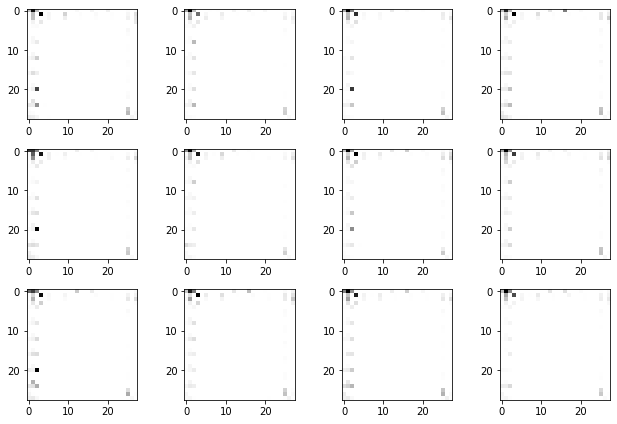

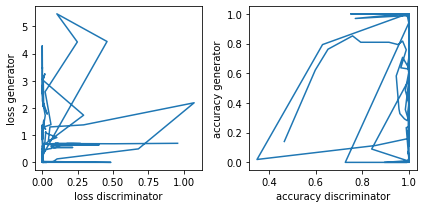

In [12]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator(batch_norm=True)
generator = make_generator(batch_norm=True)
gan = GAN(generator, discriminator, data, test_data, name="mnist-batchnorm-sequential")
history = gan.train(n_iter=10000)

post_estimation_summary(gan, history)

#  1000: loss=(0.001, 0.144), acc=(1.000, 0.996)
Iter 1000: loss=(0.000, 2.620), acc=(1.000, 0.000)
#  2000: loss=(0.000, 0.087), acc=(1.000, 1.000)
Iter 2000: loss=(0.000, 3.241), acc=(1.000, 0.000)
#  3000: loss=(0.000, 0.023), acc=(1.000, 1.000)
Iter 3000: loss=(0.000, 4.585), acc=(1.000, 0.000)
#  4000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 4000: loss=(0.000, 8.501), acc=(1.000, 0.000)
#  5000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 5000: loss=(0.000, 8.901), acc=(1.000, 0.000)
#  6000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 6000: loss=(0.000, 9.342), acc=(1.000, 0.000)
#  7000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 7000: loss=(0.000, 9.687), acc=(1.000, 0.000)
#  8000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 8000: loss=(0.000, 10.627), acc=(1.000, 0.000)
#  9000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 9000: loss=(0.000, 12.683), acc=(1.000, 0.000)
# 10000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 10000: loss=(0.000, 12.564), acc=(1.000, 0.0

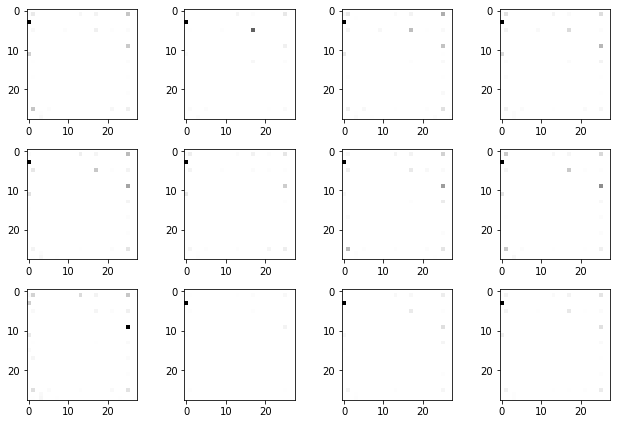

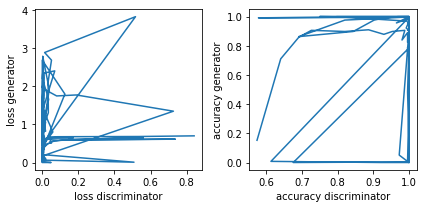

In [13]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator_functional(batch_norm=True)
generator = make_generator_functional(batch_norm=True)
gan = GAN(generator, discriminator, data, test_data,
          name="mnist-batchnorm-functional", functional=True)
history = gan.train(n_iter=10000)

post_estimation_summary(gan, history)

#  1000: loss=(0.750, 0.691), acc=(0.320, 0.520)
Iter 1000: loss=(0.767, 0.708), acc=(0.023, 0.258)
#  2000: loss=(0.680, 0.739), acc=(0.543, 0.227)
Iter 2000: loss=(0.712, 0.641), acc=(0.242, 1.000)
#  3000: loss=(0.699, 0.690), acc=(0.465, 0.551)
Iter 3000: loss=(0.675, 0.710), acc=(0.930, 0.109)
#  4000: loss=(0.693, 0.697), acc=(0.516, 0.453)
Iter 4000: loss=(0.682, 0.699), acc=(0.844, 0.188)
#  5000: loss=(0.688, 0.707), acc=(0.582, 0.324)
Iter 5000: loss=(0.687, 0.691), acc=(0.727, 0.578)
#  6000: loss=(0.689, 0.696), acc=(0.570, 0.492)
Iter 6000: loss=(0.680, 0.700), acc=(0.844, 0.227)
#  7000: loss=(0.694, 0.707), acc=(0.520, 0.336)
Iter 7000: loss=(0.676, 0.700), acc=(0.891, 0.258)
#  8000: loss=(0.690, 0.700), acc=(0.562, 0.430)
Iter 8000: loss=(0.678, 0.698), acc=(0.859, 0.344)
#  9000: loss=(0.694, 0.703), acc=(0.492, 0.402)
Iter 9000: loss=(0.673, 0.705), acc=(0.898, 0.156)
# 10000: loss=(0.693, 0.699), acc=(0.488, 0.441)
Iter 10000: loss=(0.676, 0.705), acc=(0.938, 0.094)

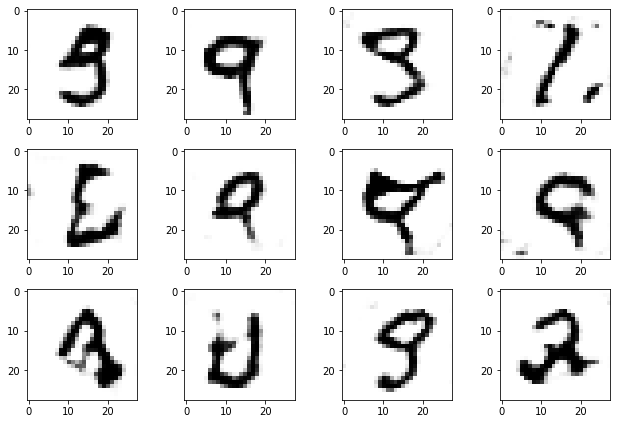

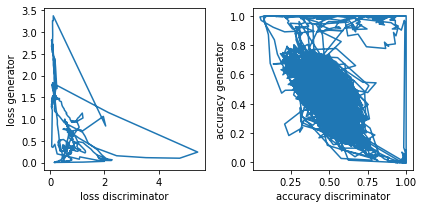

In [14]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator_functional(batch_norm=False)
generator = make_generator_functional(batch_norm=True)
gan = GAN(generator, discriminator, data, test_data,
          name="mnist-g-batchnorm-functional", functional=True)
history = gan.train(n_iter=10000)

post_estimation_summary(gan, history)

#  1000: loss=(0.000, 0.020), acc=(1.000, 1.000)
Iter 1000: loss=(0.000, 4.271), acc=(1.000, 0.000)
#  2000: loss=(0.000, 0.008), acc=(1.000, 1.000)
Iter 2000: loss=(0.000, 5.064), acc=(1.000, 0.000)
#  3000: loss=(0.000, 0.004), acc=(1.000, 1.000)
Iter 3000: loss=(0.000, 5.886), acc=(1.000, 0.000)
#  4000: loss=(0.000, 0.001), acc=(1.000, 1.000)
Iter 4000: loss=(0.000, 7.650), acc=(1.000, 0.000)
#  5000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 5000: loss=(0.000, 8.419), acc=(1.000, 0.000)
#  6000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 6000: loss=(0.000, 10.182), acc=(1.000, 0.000)
#  7000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 7000: loss=(0.000, 10.471), acc=(1.000, 0.000)
#  8000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 8000: loss=(0.000, 11.960), acc=(1.000, 0.000)
#  9000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 9000: loss=(0.000, 14.693), acc=(1.000, 0.000)
# 10000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 10000: loss=(0.000, 14.437), acc=(1.000, 0

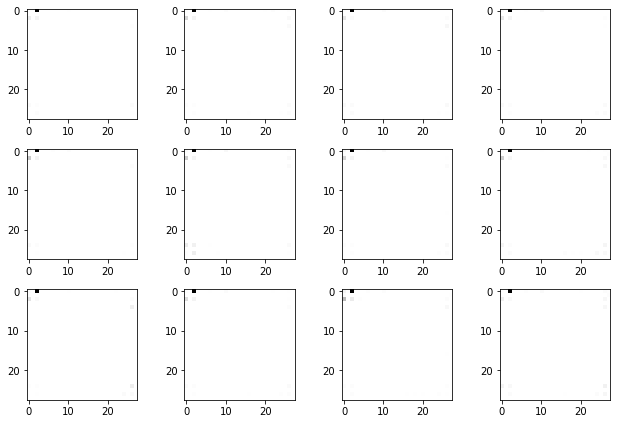

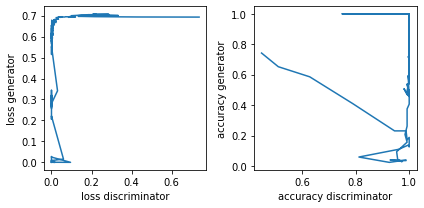

In [15]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator_functional(batch_norm=True)
generator = make_generator_functional(batch_norm=False)
gan = GAN(generator, discriminator, data, test_data,
          name="mnist-d-batchnorm-functional", functional=True)
history = gan.train(n_iter=10000)

post_estimation_summary(gan, history)

#  1000: loss=(0.234, 0.004), acc=(0.916, 1.000)
Iter 1000: loss=(0.000, 6.225), acc=(1.000, 0.000)
#  2000: loss=(0.531, 0.023), acc=(0.731, 1.000))
Iter 2000: loss=(0.009, 4.575), acc=(1.000, 0.000)
#  3000: loss=(0.667, 1.113), acc=(0.607, 0.126)
Iter 3000: loss=(0.769, 0.496), acc=(0.266, 0.992)
#  4000: loss=(0.657, 0.267), acc=(0.634, 0.988)
Iter 4000: loss=(0.167, 1.682), acc=(1.000, 0.000)
#  5000: loss=(0.638, 1.827), acc=(0.640, 0.005)
Iter 5000: loss=(1.675, 0.207), acc=(0.000, 1.000)
#  6000: loss=(0.666, 3.244), acc=(0.619, 0.001))
Iter 6000: loss=(3.092, 0.041), acc=(0.000, 1.000)
#  7000: loss=(0.682, 2.727), acc=(0.614, 0.014)
Iter 7000: loss=(4.075, 0.032), acc=(0.000, 1.000)
#  8000: loss=(0.092, 0.013), acc=(0.977, 1.000)
Iter 8000: loss=(0.003, 4.127), acc=(1.000, 0.000)
#  9000: loss=(0.458, 0.239), acc=(0.790, 0.967)
Iter 9000: loss=(0.132, 1.602), acc=(1.000, 0.000)
# 10000: loss=(0.316, 0.044), acc=(0.860, 1.000)
Iter 10000: loss=(0.014, 3.440), acc=(1.000, 0.00

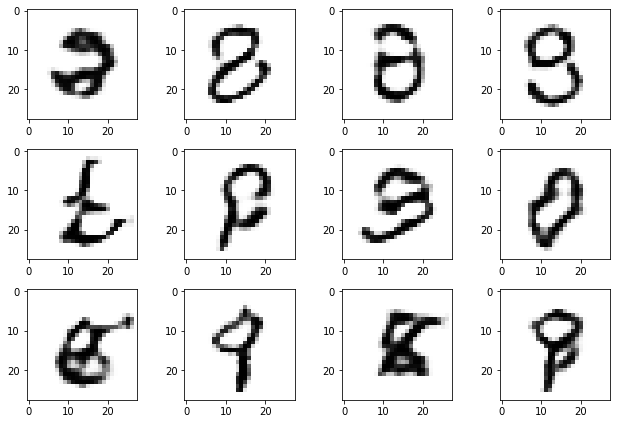

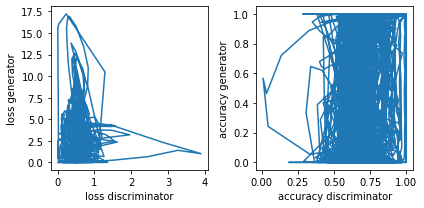

In [16]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator_functional(batch_norm=True)
generator = make_generator_functional(batch_norm=True)
gan = GAN(generator, discriminator, data, test_data,
          name="mnist-batchnorm-functional-stacked-update-large-batch", functional=True)
history = gan.train(n_iter=10000, batchsize=1024, update_discriminator_separately=False)

post_estimation_summary(gan, history)

#  1000: loss=(0.000, 0.013), acc=(1.000, 1.000)
Iter 1000: loss=(0.000, 4.627), acc=(1.000, 0.000)
#  2000: loss=(0.000, 0.004), acc=(1.000, 1.000)
Iter 2000: loss=(0.000, 5.803), acc=(1.000, 0.000)
#  3000: loss=(0.000, 0.002), acc=(1.000, 1.000)
Iter 3000: loss=(0.000, 6.449), acc=(1.000, 0.000)
#  4000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 4000: loss=(0.001, 8.156), acc=(1.000, 0.000)
#  5000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 5000: loss=(0.000, 11.574), acc=(1.000, 0.000)
#  6000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 6000: loss=(0.000, 12.593), acc=(1.000, 0.000)
#  7000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 7000: loss=(0.000, 17.627), acc=(1.000, 0.000)
#  8000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 8000: loss=(0.000, 17.740), acc=(1.000, 0.000)
#  9000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 9000: loss=(0.000, 18.890), acc=(1.000, 0.000)
# 10000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 10000: loss=(0.000, 19.263), acc=(1.000, 

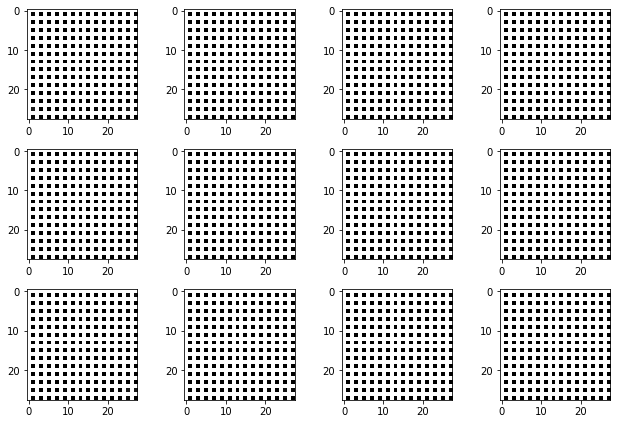

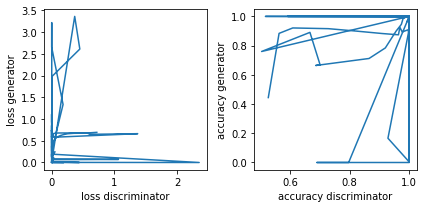

In [17]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator_functional(batch_norm=True)
generator = make_generator_functional(batch_norm=True)
gan = GAN(generator, discriminator, data, test_data,
          name="mnist-batchnorm-functional-large-batch", functional=True)
history = gan.train(n_iter=10000, batchsize=1024)

post_estimation_summary(gan, history)